In [22]:
## IMPORT NECESSARY PACKAGES #1

from pprint import pprint
# import pandasql as ps
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from zipfile import ZipFile
from io import BytesIO
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
# InteractiveShell.ast_node_interactivity = "all"
# CSS = """
# .output {
#     flex-direction: row;
# }
# """
# HTML('<style>{}</style>'.format(CSS))

sns.set()

In [23]:
## LOAD TORONTO DATASETS & DELETE WEIRD 

restaurants_df = pd.read_csv("datasets/vegas_pr2_restaurants.csv", sep=',', encoding='utf-8')
reviews_df = pd.read_csv("datasets/american_reviews.csv", sep='\t', encoding='utf-8')

#del(restaurants_df['Unnamed: 0'])
del(reviews_df['Unnamed: 0'])

#restaurants_df = restaurants_df[restaurants_df['RestaurantsPriceRange2'] == 2]
reviews_df = reviews_df.loc[reviews_df['business_id'].isin(restaurants_df.business_id)]

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
restaurants_df.head()

,address,BikeParking,BusinessAcceptsCreditCards,Caters,CoatCheck,GoodForKids,HappyHour,HasTV,OutdoorSeating,RestaurantsDelivery,...,noise_average,noise_loud,noise_quiet,noise_very_loud,price_range_1,price_range_2,price_range_3,price_range_4,attire_casual,attire_dressy
0,2227 N Rampart Blvd,True,True,False,NaN,True,NaN,True,False,False,...,True,False,False,False,False,True,False,False,True,False
1,2201 S Fort Apache Rd,True,True,False,NaN,True,NaN,True,True,False,...,True,False,False,False,False,True,False,False,True,False
2,7530 S Las Vegas Blvd,True,True,True,False,True,True,True,False,False,...,True,False,False,False,False,True,False,False,True,False
3,2101 Texas Star Ln,True,True,False,NaN,True,NaN,False,False,False,...,True,False,False,False,False,True,False,False,True,False
4,10490 W Cheyenne Ave,True,True,False,NaN,True,NaN,True,False,False,...,True,False,False,False,False,True,False,False,True,False


In [25]:
reviews_df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,1.0,LZp4UX5zK3e-c5ZGSeo3kA,1.0,Terrible. Dry corn bread. Rib tips were all fa...,3.0,msQe1u7Z_XuqjGoqhB0J5g
2,faPVqws-x-5k2CQKDNtHxw,0,2015-03-25,2.0,QHueaxKHuBpbDOkWb0Cyfw,1.0,People please...the only good thing about this...,2.0,0AIj432MvowwghnpurtP-Q
5,3kdSl5mo9dWC4clrQjEDGg,0,2015-10-17,1.0,Bay72mIfR-yGKZf_S9xQeg,4.0,????????????????????????????????????\r\n?????7...,0.0,5oy_MM1skY1LvmdNNVVM5Q
6,f4x1YBxkLrZg652xt2KR5g,0,2015-10-17,0.0,YeRRSIod4aDvNDQKvbSWnA,3.0,????????????????????\r\n???Link Hotel???????\r...,0.0,5oy_MM1skY1LvmdNNVVM5Q
8,wuQDMDlqM17jQNo0lYQZ7g,0,2014-06-23,0.0,5kMnY9eUsskyknVszeqWQw,5.0,One of the best experiences I have had in Vega...,0.0,FHwl6kaKdD5-KAnfVb_pKQ


In [26]:
print('Number of categories listed',restaurants_df['city'].nunique())

restaurants_df['city'].head()

Number of categories listed 1


0    Las Vegas
1    Las Vegas
2    Las Vegas
3    Las Vegas
4    Las Vegas
Name: city, dtype: object

In [27]:
len(restaurants_df)

801

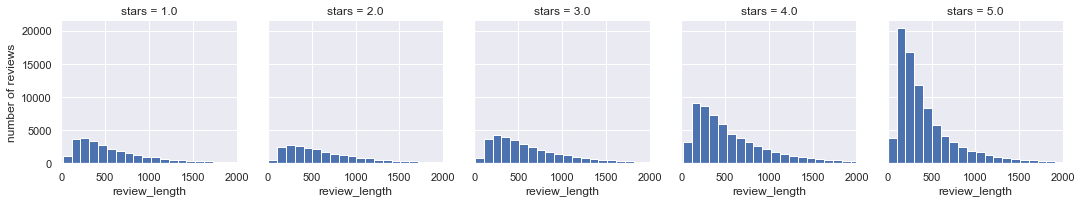

In [28]:
# check how the review lengths are distributed
reviews_df['review_length'] = reviews_df.text.map(len)

ax = sns.FacetGrid(data=reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)

ax.axes[0][0].set(ylabel='number of reviews');

In [29]:
pos_reviews = reviews_df.text[reviews_df.stars>3.5].values
neg_reviews = reviews_df.text[reviews_df.stars<=3.5].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  147,567
Negative Reviews:  85,357


In [30]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'toronto', 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [31]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

CPU times: user 5.55 s, sys: 210 ms, total: 5.76 s
Wall time: 6.3 s


In [32]:
# Store TFIDF vectors in a Pandas DataFrame to investigate further
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [33]:
no_top_words = 10

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 10 words in POSITIVE reviews:[('great',), ('place',), ('service',), ('burger',), ('time',), ('order',), ('vegas',), ('amazing',), ('delicious',), ('chicken',)]
Top 10 words in NEGATIVE reviews:[('order',), ('service',), ('place',), ('burger',), ('time',), ('great',), ('chicken',), ('minutes',), ('fries',), ('restaurant',)]


In [34]:
# delete dataframes to save memory
del neg_df
del pos_df

In [35]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [36]:
# create LSA model
num_topics = 7
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

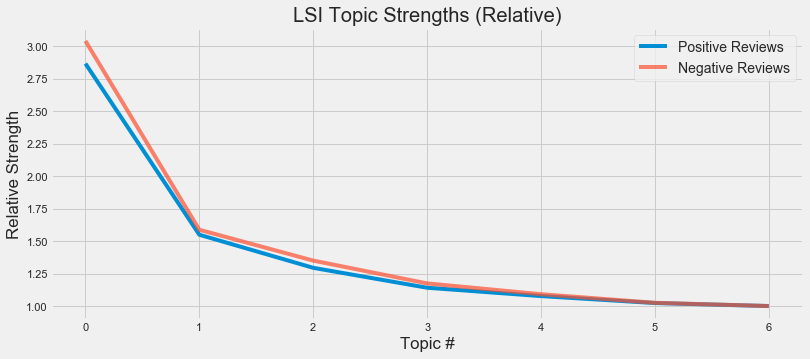

In [37]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [38]:
topics_to_print = 5

In [39]:
# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.281*"great" + 0.229*"place" + 0.224*"burger" + 0.196*"service" + '
  '0.145*"order" + 0.144*"time" + 0.137*"vegas" + 0.129*"amazing" + '
  '0.127*"breakfast" + 0.126*"chicken"'),
 (1,
  '-0.784*"burger" + -0.294*"fries" + 0.223*"great" + 0.172*"breakfast" + '
  '0.127*"service" + 0.103*"place" + -0.096*"truffle" + -0.093*"shake" + '
  '-0.085*"cheese" + 0.077*"friendly"'),
 (2,
  '-0.567*"great" + 0.288*"chicken" + -0.250*"service" + -0.215*"burger" + '
  '0.184*"order" + 0.161*"fried" + 0.132*"waffles" + 0.122*"breakfast" + '
  '-0.118*"atmosphere" + 0.117*"eggs"'),
 (3,
  '-0.604*"breakfast" + -0.208*"pancakes" + -0.190*"burger" + 0.174*"bar" + '
  '0.162*"happy" + -0.159*"eggs" + 0.152*"hour" + 0.150*"chicken" + '
  '-0.144*"best" + -0.126*"vegas"'),
 (4,
  '0.426*"chicken" + 0.370*"great" + -0.328*"place" + -0.281*"love" + '
  '0.239*"service" + 0.204*"fried" + 0.191*"waffles" + -0.136*"bar" + '
  '-0.123

In [40]:

# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.221*"order" + 0.215*"burger" + 0.187*"place" + 0.187*"service" + '
  '0.150*"time" + 0.126*"minutes" + 0.116*"great" + 0.114*"fries" + '
  '0.110*"chicken" + 0.106*"table"'),
 (1,
  '0.774*"burger" + 0.280*"fries" + -0.152*"minutes" + 0.108*"cheese" + '
  '-0.107*"service" + -0.100*"table" + -0.089*"server" + -0.087*"time" + '
  '0.083*"shake" + -0.077*"took"'),
 (2,
  '0.333*"burger" + 0.287*"minutes" + -0.241*"chicken" + -0.212*"buffet" + '
  '-0.205*"breakfast" + 0.146*"waited" + 0.143*"table" + 0.133*"took" + '
  '0.126*"order" + -0.121*"eggs"'),
 (3,
  '0.420*"chicken" + 0.328*"order" + -0.290*"buffet" + -0.190*"place" + '
  '-0.168*"bar" + -0.150*"service" + -0.147*"price" + -0.139*"vegas" + '
  '0.132*"fried" + 0.127*"salad"'),
 (4,
  '-0.485*"breakfast" + -0.308*"eggs" + 0.300*"chicken" + 0.225*"bar" + '
  '-0.168*"pancakes" + -0.165*"coffee" + 0.159*"salad" + -0.145*"toast" + '
  '-0.143*"hash" + -0.

In [41]:

%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 5.69 s, sys: 310 ms, total: 6 s
Wall time: 9.04 s


In [42]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.097*order, 0.946*time, 0.797*menu, 0.637*nice, 0.637*restaurant, 0.602*bar
Topic 1:   3.140*burger, 1.164*fries, 0.378*truffle, 0.354*shake, 0.331*cheese, 0.258*best
Topic 2:   2.836*great, 1.480*service, 0.481*atmosphere, 0.421*excellent, 0.405*awesome, 0.395*friendly
Topic 3:   2.221*breakfast, 0.854*pancakes, 0.684*eggs, 0.438*toast, 0.429*coffee, 0.370*hash
Topic 4:   2.317*chicken, 1.090*fried, 0.981*waffles, 0.297*bacon, 0.292*cheese, 0.274*sage
Topic 5:   2.331*place, 1.484*love, 0.950*amazing, 0.780*vegas, 0.531*best, 0.520*staff

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.518*minutes, 1.344*order, 1.045*table, 0.929*took, 0.906*server, 0.844*time
Topic 1:   3.081*burger, 1.086*fries, 0.341*cheese, 0.324*shake, 0.244*better, 0.233*medium
Topic 2:   1.484*place, 0.948*service, 0.895*great, 0.814*bar, 0.481*pretty, 0.477*nice
Topic 3:   1.

In [43]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])


4815
I visited this little restaurant with my best friend on our way out of Las Vegas on my birthday weekend. 

We were greeted and seated promptly. The menu had some super appealing items on it, so it was hard to choose. The service was good although I felt like we were mis-heard on a few occasions, and it's not as though it's terribly loud in there. (I asked for water and said it three times, but he brought me coffee AND orange juice? Not sure how water sounds like coffee or orange juice.) 

The decor was modern and cool, as was the staff.

After a lot of inner turmoil, I decided on the two eggs any style with chive potatoes and toast. The potatoes were awesome. The toast was soft and thick, which was nice. My friend had deviled eggs, if I'm not mistaken. She was happy with hers. We shared a large pancake, which both of us thought was just OK--nothing special. But it looked so fluffy!

I think that overall it is worth the price and the experience. The food quality is great, as is the

In [44]:
# look at a random negative review
review_num = np.random.randint(0, high=len(random_neg))
print(review_num)
print(random_neg[review_num])


14024
Food here is generally average, it's basically a fancy ice cream parlor.  I order a GIANT hot dog, more than any one person should even try to eat.  Service is seriously lacking, but the reason we keep coming back is the Frrrozen Hot Chocolate.  It is honestly the flavor of heaven in my dreams.  It's not cheap, but it is amazing.  I wish we had one in LA just so that I could get my fix without the 4 hour desert drive.  Until then, I'll keep coming back!


In [45]:

# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [46]:

# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 0.994
Outstanding food and service - Yardbird is not to miss. We booked the room for a private event. Magin from the sales office was very responsive and helped me arrange a pre fixe menu which made logistics very easy. 

The menu was incredible; I now understand all the rave reviews. The savory, crisp-chewy cheddar waffle was my favorite. Others enjoyed the Yardbird Benedict, although I found it a bit on the rich side. 

The room is lovely, decorated with a private photo collection from John Wayne. The team taking care of us was fantastic. A fantastic and memorable experience!
--------------------------------------------------
>> Similarity 0.994
Outstanding food and service - Yardbird is not to miss. We booked the room for a private event. Magin from the sales office was very responsive and helped me arrange a pre fixe menu which made logistics very easy. 

The menu was incredible; I now understand all the rave reviews.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [48]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [49]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

CPU times: user 6min 57s, sys: 4min 10s, total: 11min 8s
Wall time: 18min 30s


In [50]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.042*"burger" + 0.017*"fries" + 0.012*"place" + 0.011*"great" + '
  '0.011*"time" + 0.010*"service" + 0.009*"order"'),
 (1,
  '0.032*"great" + 0.020*"service" + 0.019*"place" + 0.011*"chicken" + '
  '0.010*"amazing" + 0.010*"delicious" + 0.009*"order"'),
 (2,
  '0.012*"chicken" + 0.011*"order" + 0.009*"cheese" + 0.009*"sauce" + '
  '0.007*"delicious" + 0.006*"fries" + 0.006*"burger"'),
 (3,
  '0.017*"place" + 0.015*"great" + 0.010*"time" + 0.010*"vegas" + '
  '0.010*"service" + 0.008*"love" + 0.007*"burger"'),
 (4,
  '0.019*"breakfast" + 0.016*"place" + 0.011*"great" + 0.010*"order" + '
  '0.009*"eggs" + 0.008*"vegas" + 0.008*"time"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.012*"breakfast" + 0.011*"place" + 0.008*"service" + 0.008*"buffet" + '
  '0.008*"price" + 0.008*"vegas" + 0.008*"order"'),
 (1,
  '0.012*"menu" + 0.011*"service" + 0.011*"order

## Continuing with NMF

In [51]:
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.097*order, 0.946*time, 0.797*menu, 0.637*nice, 0.637*restaurant, 0.602*bar
Topic 1:   3.140*burger, 1.164*fries, 0.378*truffle, 0.354*shake, 0.331*cheese, 0.258*best
Topic 2:   2.836*great, 1.480*service, 0.481*atmosphere, 0.421*excellent, 0.405*awesome, 0.395*friendly
Topic 3:   2.221*breakfast, 0.854*pancakes, 0.684*eggs, 0.438*toast, 0.429*coffee, 0.370*hash
Topic 4:   2.317*chicken, 1.090*fried, 0.981*waffles, 0.297*bacon, 0.292*cheese, 0.274*sage
Topic 5:   2.331*place, 1.484*love, 0.950*amazing, 0.780*vegas, 0.531*best, 0.520*staff


In [52]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #17123
-------------------------
I've been here about 4-5 times and no one ever told me about the rewards card.. The normal girl that rings me out isn't very friendly nor does she smile much which is a huge turn off in any customer service establishment.
However! What saved my opinion on this place was Dakota! Absolutely incredible guy awesome personality and signed me up for the loyalty program and was very apologetic that no one else mentioned it.
I'm a manager and honestly this is what I strive to have my employees be like.
Great food and smoothies plus it's a healthy place to eat which I enjoy!
-------------------------
Topic 5: 0.0379
Topic 2: 0.0267
Topic 0: 0.0053
Topic 1: 0.0022
Topic 3: 0.0000
Topic 4: 0.0000


In [53]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.518*minutes, 1.344*order, 1.045*table, 0.929*took, 0.906*server, 0.844*time
Topic 1:   3.081*burger, 1.086*fries, 0.341*cheese, 0.324*shake, 0.244*better, 0.233*medium
Topic 2:   1.484*place, 0.948*service, 0.895*great, 0.814*bar, 0.481*pretty, 0.477*nice
Topic 3:   1.778*chicken, 0.815*salad, 0.720*order, 0.614*cheese, 0.601*sandwich, 0.568*fried
Topic 4:   1.787*breakfast, 1.187*eggs, 0.672*pancakes, 0.609*coffee, 0.599*hash, 0.592*toast
Topic 5:   2.097*buffet, 0.457*vegas, 0.423*price, 0.392*buffets, 0.352*better, 0.347*selection


In [54]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #18063
-------------------------
Dear Lord, stay away. I'm reminded of the commissary in college eating here. Granted, the dishes and variety is far superior to what we had in college. The quality is not up to standard. The lunch price of $19.99 is fair for a buffet but, the overall quality of the dishes still doesn't support it. 

The Luxor could spend a bit more effort in delivering a higher quality experience
-------------------------
Topic 5: 0.0761
Topic 2: 0.0068
Topic 3: 0.0020
Topic 1: 0.0015
Topic 0: 0.0000
Topic 4: 0.0000


## Topic Modeling All Reviews 
At this point, we can see that our topics are relatively interpretable and match along with the reviews they're trying to categorize. Let's proceed with topic modeling all reviews and businesses using NMF.

In [55]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  147,567
Negative Reviews:  85,357


In [56]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

CPU times: user 31 s, sys: 9.11 s, total: 40.1 s
Wall time: 1min 33s


In [57]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 28.2 s, sys: 1.06 s, total: 29.3 s
Wall time: 31 s


In [58]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   1.770*order, 1.402*time, 1.259*menu, 1.122*nice, 1.053*restaurant, 1.039*bar
Topic 1:   5.063*burger, 1.902*fries, 0.595*shake, 0.578*truffle, 0.539*cheese, 0.429*onion
Topic 2:   4.700*great, 2.268*service, 0.766*atmosphere, 0.632*awesome, 0.622*excellent, 0.501*friendly
Topic 3:   3.541*breakfast, 1.441*pancakes, 1.180*eggs, 0.787*toast, 0.660*coffee, 0.630*hash
Topic 4:   3.844*chicken, 1.750*fried, 1.632*waffles, 0.485*bacon, 0.472*salad, 0.455*cheese
Topic 5:   3.549*place, 2.208*love, 1.840*amazing, 1.427*vegas, 1.275*best, 1.037*staff

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   2.159*minutes, 1.883*order, 1.455*table, 1.350*took, 1.314*server, 1.177*wait
Topic 1:   4.353*burger, 1.590*fries, 0.448*shake, 0.438*cheese, 0.336*medium, 0.325*onion
Topic 2:   2.095*place, 1.470*service, 1.244*great, 1.163*bar, 0.687*nice, 0.668*bad
Topic 3:   2.496*chicken, 1.080*salad, 

In [59]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'menu/experience', 1:'burger/fries', 2:'service/atmosphere', 
              3:'breakfast/pancakes', 4:'chicken/waffles', 5:'location/atmosphere'}

neg_topics = {0:'wait/table', 1:'burger/fries', 2:'bad_service', 
              3:'chicken/salad', 4:'breakfast/eggs', 5:'buffet/price'}

## Adding Topic Weights to Pandas DataFrame

In [60]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = reviews_df[['business_id', 'stars', 'text', 'review_length']][reviews_df.stars>3].reset_index()
df_neg = reviews_df[['business_id', 'stars', 'text', 'review_length']][reviews_df.stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [61]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0. 0. 0. 0. 0. 0.]
Sum of weights:  0.0


In [62]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0. 0. 0. 0. 0. 0.]]
Sum of normalized weights:  0.0


In [63]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [64]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,jtQARsP6P-LbkyjbO1qNGg,1.0,Terrible. Dry corn bread. Rib tips were all fa...,156.0,0.000000,0.023054,0.000867,0.751708,0.000000,0.224370
1,faPVqws-x-5k2CQKDNtHxw,1.0,People please...the only good thing about this...,622.0,0.253096,0.013696,0.615945,0.117262,0.000000,0.000000
2,ZtsnwjxjzMUI6tDZNrJUeA,1.0,If there was an option to give this place nega...,734.0,0.000000,0.000000,0.304793,0.000000,0.101528,0.593679
3,NvKNe9DnQavC9GstglcBJQ,1.0,My friends and I went into Grand Lux Cafe at t...,580.0,0.204687,0.061922,0.377754,0.276894,0.078744,0.000000
4,jdAdf7keZac1idbgNKG2pw,1.0,Went with my daughter tonight and was refused ...,500.0,0.000000,0.965198,0.034802,0.000000,0.000000,0.000000


In [65]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [66]:
df_pos_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,4.875000,40,743.800000,0.317745,0.103765,0.176195,0.008446,0.142640,0.251209
1,-JfncbVURtvuzBbof40o1w,4.176471,34,556.735294,0.310097,0.054310,0.112984,0.281021,0.143596,0.097991
2,-OEIW0dO96-492qa_luxaw,4.557143,210,669.052381,0.339588,0.072047,0.272646,0.016357,0.048552,0.250810
3,-PGsEXB6DFTVKa1eDOlzWA,4.660550,109,459.532110,0.217718,0.029131,0.268024,0.218575,0.080800,0.185753
4,-SGZcGqnsp_uRIjKP2RGZg,4.666667,6,343.666667,0.332862,0.000000,0.251487,0.192183,0.012526,0.210942


In [67]:
df_neg_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,2.000000,1,1657.000000,0.111447,0.285122,0.393136,0.000000,0.000000,0.210296
1,-JfncbVURtvuzBbof40o1w,1.430769,65,642.630769,0.172101,0.128016,0.316126,0.162161,0.115720,0.105877
2,-OEIW0dO96-492qa_luxaw,1.363636,33,841.121212,0.228583,0.107326,0.225116,0.227096,0.146760,0.065119
3,-PGsEXB6DFTVKa1eDOlzWA,1.400000,65,940.276923,0.165311,0.094164,0.321069,0.176041,0.137894,0.105520
4,-SGZcGqnsp_uRIjKP2RGZg,1.000000,3,632.000000,0.082803,0.000000,0.207097,0.343421,0.292640,0.074038


## Adding in Business Information 

In [75]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(restaurants_df[['business_id', 'name', 'city', 'stars', 'latitude', 'longitude']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars_y', 'latitude', 'longitude', 0, 1, 2, 3, 4, 5]]

df_neg_tot = df_neg_bsns.merge(restaurants_df[['business_id', 'name', 'city', 'stars', 'latitude', 'longitude']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars_y', 'latitude', 'longitude', 0, 1, 2, 3, 4, 5]]

In [76]:
# peek into business/topic distributions
df_neg_tot.head(10)

,business_id,name,city,stars_y,latitude,longitude,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,Toddy Shop,Las Vegas,5.0,36.171428,-115.245080,0.111447,0.285122,0.393136,0.000000,0.000000,0.210296
1,-JfncbVURtvuzBbof40o1w,The Cafe at Monte Carlo,Las Vegas,2.5,36.104781,-115.174663,0.172101,0.128016,0.316126,0.162161,0.115720,0.105877
2,-OEIW0dO96-492qa_luxaw,Aces & Ales,Las Vegas,4.0,36.121423,-115.064716,0.228583,0.107326,0.225116,0.227096,0.146760,0.065119
3,-PGsEXB6DFTVKa1eDOlzWA,Black Bear Diner,Las Vegas,3.5,36.142663,-115.278284,0.165311,0.094164,0.321069,0.176041,0.137894,0.105520
4,-SGZcGqnsp_uRIjKP2RGZg,Ranch House Grille,Las Vegas,3.5,36.042985,-115.288938,0.082803,0.000000,0.207097,0.343421,0.292640,0.074038
5,-U7tvCtaraTQ9b0zBhpBMA,MGM Grand Buffet,Las Vegas,2.5,36.102091,-115.171778,0.208903,0.087847,0.314483,0.166045,0.109821,0.112901
6,-UtYWvCnUppcSaC_u1pTYQ,Kopper Keg Restaurant & Lounge,Las Vegas,4.0,36.100981,-115.074497,0.000000,0.235492,0.000000,0.677922,0.086586,0.000000
7,-Ylpy3VyRWwubf9dysuwjQ,The Cheesecake Factory,Las Vegas,3.5,36.117343,-115.176362,0.198620,0.100755,0.283538,0.228635,0.114589,0.073863
8,-a857YYdjzgOdOjFFRsRXQ,Beer Park,Las Vegas,3.5,36.111993,-115.172425,0.250286,0.086495,0.295853,0.169394,0.101435,0.096537
9,-kbPPBNsIPDfMfgUGO7QhA,Kopper Keg South,Las Vegas,4.0,36.029110,-115.119387,0.178385,0.050138,0.621796,0.061762,0.048663,0.039256


In [77]:
scores = df_neg_bsns[df_neg_bsns.business_id == '-UtYWvCnUppcSaC_u1pTYQ'].iloc[:,-6:].values
print(restaurants_df[restaurants_df.business_id == '-UtYWvCnUppcSaC_u1pTYQ']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in neg_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, neg_topics[n], scores[0][n]))

Kopper Keg Restaurant & Lounge - Positive Reviews
------------------------------------
Topic 0: wait/table         > 0.0000
Topic 1: burger/fries       > 0.2355
Topic 2: bad_service        > 0.0000
Topic 3: chicken/salad      > 0.6779
Topic 4: breakfast/eggs     > 0.0866
Topic 5: buffet/price       > 0.0000


In [79]:
%%time
# write to CSV
df_pos_tot.to_csv('pos_bsns.csv')
df_neg_tot.to_csv('neg_bsns.csv')
df_pos.to_csv('pos_reviews.csv')
df_neg.to_csv('neg_reviews.csv')

CPU times: user 9.09 s, sys: 914 ms, total: 10 s
Wall time: 10.7 s


In [81]:
df_neg_tot.shape

(751, 12)